# Figure 5b: H5N1 shared SNPs permutation test

June 6, 2019

Trevor suggested that I run some simulations randomly assigning polymorphic sites to random parts of the genome and then seeing how much sharing occurs when this is random. The idea here is that we have identified 9 polymorphic amino acid sites that are shared in at least 2 samples. However, we don't have any great idea about whether that is more or less sharing than we would expect by chance alone. The idea is to do the following: 

1. For each gene and individual, calculate the number of amino acid polymorphisms present in the sample. Record that. 
2. Simulate the same number of individuals and gene segments that we have, and assign them polymorphism at random sites.
3. Compute how many SNPs polymorphic sites are shared among at least 2 samples. 
4. Repeat for 10,000 simulations to generate a distribution. 
5. Compare with the actual number of observed shared sites (3 and 9). 

In [1]:
# import necessary modules
import sys, subprocess, glob, os, shutil, re, importlib, Bio, csv
from subprocess import call
from Bio import SeqIO
import numpy as np
import pandas as pd
import random
from random import randint
from collections import Counter
import rpy2
%load_ext rpy2.ipython

In [2]:
# define colors 
human_color = "#C75643"
duck_color = "#545AB7"

## Step 1: Write the simulator 

I will first write the simulator that will take as input an array of samples with polymorphic sites in their genomes and the number of simulations to perform. This will then randomly assign the sites and run the simulation. 

In [4]:
def simulate_shared_sites(polymorphisms_array, num_sites_array, num_sims):
    
    iteration_results = {"PB2":[], "PB1":[], "PA":[], "HA":[], "NP":[],"NA":[], "M1":[], "M2":[], "NS1":[], "NEP":[]}
    
    for i in range(0, num_sims):
        
        results = {"PB2":[], "PB1":[], "PA":[], "HA":[], "NP":[],"NA":[], "M1":[], "M2":[], "NS1":[], "NEP":[]}
    
        for sample in polymorphisms_array:
            for gene in polymorphisms_array[sample]:
                
                # define the number of possible sites
                num_possible_sites = range(0,num_sites_array[sample][gene])
                
                # specify how many sites to choose
                num_sites_to_draw = polymorphisms_array[sample][gene]          
                try:
                    # take a random draw
                    random_draw = (random.sample(num_possible_sites, num_sites_to_draw))
                except: 
                    print("there was an error with the number of available sites vs. the draw size")
                    print(sample, gene, num_possible_sites, num_sites_to_draw)
            
            
                # write results to their respective lists
                for r in random_draw:
                    results[gene].append(r)
        
        # once iteration is over, count the number of repeat elements in each list 
        for gene in results:
            count=Counter(results[gene]).values()
            
            more_than_once = 0
            for i in count:
                if i > 1:
                    more_than_once += 1
            
            iteration_results[gene].append(more_than_once)
    
    return(iteration_results)                    

## Step 2: Generate the correct input arrays from actual data

I now need to actually populate these arrays with the proper values for each sample (how many polymorphic sites are present and how many amino acid sites had the possibility of having a SNP called there). 

### Step 2a: generate SNP array

Use the duplicate reads removed SNP data to generate a dictionary of the number of amino acid site changes (both synonyous and nonsynonymous) within the coding region for each gene for each sample. 

In [6]:
# use duplicate reads removed data
snps_file = "../data/within-host-snvs-1%.tsv"

In [7]:
## first generate the array of the number of SNPs per gene per sample

SNPs_human = {}
SNPs_duck = {}

with open(snps_file, "r") as infile: 
    for line in infile: 
        if "reference_position" not in line: 
            sample = line.split("\t")[0]
            sample = "_".join(sample.split("_")[:-1])
            gene = line.split("\t")[2]
            gene = gene.replace("_circ","")
            cds_change = line.split("\t")[7]
            aa_change = line.split("\t")[6]
            aa_site = aa_change[3:-3]
            
            if "duck" in sample: 
                species = "duck"
            else: 
                species = "human"
            
            if species == "human":
                if cds_change == "synonymous" or cds_change == "nonsynonymous":
                    if sample not in SNPs_human:
                        SNPs_human[sample] = {"PB2":[], "PB1":[], "PA":[], "HA":[], "NP":[],"NA":[], "M1":[], "M2":[], "NS1":[], "NEP":[]}
                        SNPs_human[sample][gene].append(aa_site)
                    
                    elif sample in SNPs_human:
                        if aa_site not in SNPs_human[sample][gene]:
                            SNPs_human[sample][gene].append(aa_site)

            elif species == "duck":
                if cds_change == "synonymous" or cds_change == "nonsynonymous":
                    if sample not in SNPs_duck:
                        SNPs_duck[sample] = {"PB2":[], "PB1":[], "PA":[], "HA":[], "NP":[],"NA":[], "M1":[], "M2":[], "NS1":[], "NEP":[]}
                        SNPs_duck[sample][gene].append(aa_site)
                    
                    elif sample in SNPs_duck:
                        if aa_site not in SNPs_duck[sample][gene]:
                            SNPs_duck[sample][gene].append(aa_site)
                        

SNPs_human2 = {}
SNPs_duck2 = {}

for sample in SNPs_human:
    SNPs_human2[sample] = {}
    for gene in SNPs_human[sample]:
        number_aa_snvs = len(SNPs_human[sample][gene])
        SNPs_human2[sample][gene] = number_aa_snvs

for sample in SNPs_duck:
    SNPs_duck2[sample] = {}
    for gene in SNPs_duck[sample]:
        number_aa_snvs = len(SNPs_duck[sample][gene])
        SNPs_duck2[sample][gene] = number_aa_snvs

                            
print(SNPs_human2)
print(SNPs_duck2)

{'AA4KNL706F512_A_Cambodia_X0128304_2013': {'PB2': 11, 'PB1': 0, 'PA': 7, 'HA': 11, 'NP': 8, 'NA': 4, 'M1': 7, 'M2': 1, 'NS1': 4, 'NEP': 1}, 'AJ4MBL723F512_A_CAMBODIA_V0401301_2011': {'PB2': 6, 'PB1': 8, 'PA': 9, 'HA': 12, 'NP': 6, 'NA': 9, 'M1': 1, 'M2': 0, 'NS1': 0, 'NEP': 0}, 'AJ4MBL718F513_A_CAMBODIA_V0417301_2011': {'PB2': 2, 'PB1': 0, 'PA': 3, 'HA': 6, 'NP': 2, 'NA': 3, 'M1': 0, 'M2': 1, 'NS1': 0, 'NEP': 0}, 'AJ4MBL720F513_A_Cambodia_W0112303_2012': {'PB2': 3, 'PB1': 2, 'PA': 6, 'HA': 1, 'NP': 3, 'NA': 0, 'M1': 0, 'M2': 0, 'NS1': 0, 'NEP': 0}, 'AJ4MBL720F514_A_Cambodia_X0125302_2013': {'PB2': 3, 'PB1': 8, 'PA': 2, 'HA': 2, 'NP': 0, 'NA': 2, 'M1': 1, 'M2': 1, 'NS1': 1, 'NEP': 0}, 'AJ4MBL723F514_A_Cambodia_X0207301_2013': {'PB2': 0, 'PB1': 4, 'PA': 8, 'HA': 3, 'NP': 1, 'NA': 2, 'M1': 3, 'M2': 0, 'NS1': 1, 'NEP': 1}, 'AJ4MBL718F515_A_Cambodia_X0219301_2013': {'PB2': 1, 'PB1': 0, 'PA': 4, 'HA': 0, 'NP': 2, 'NA': 0, 'M1': 0, 'M2': 0, 'NS1': 0, 'NEP': 0}, 'AJ4MBL720F516_A_Cambodia_X103

### Step 2b: generate array with the number of possible amino acid sites

Here I am calculating the number of amino acid sites at which a SNP could have been called based on the pileup file from the duplicate reads removed data. For each site, a SNP should not have been called if the coverage was less than 100x. I am also only including SNPs called within the coding region, so I am using the CDS coordinates from the gtf files for each sample to delineate the number of sites uniquely for each sample. 

In [8]:
# now generate the number of amino acid sites per gene 

pileups = []
for f in glob.glob("../data/pileup-files/*"):
    pileups.append(f)
    
print(len(pileups))

13


In [9]:
# read in gtfs from gtf directory to get the proper coding regions for each gene and sample 
gtfs = []

for f in glob.glob("../data/gtfs/*"):
    gtfs.append(f)

In [10]:
# read in gtf file with coding region coordinates
def define_coding_regions(gtf_list):

    coding_regions = {"human":{}, "duck":{}}
    
    for gtf_file in gtf_list:

        with open(gtf_file, "r") as csvfile: 
            reader = csv.reader(csvfile, delimiter="\t")
            for row in reader:
                if "CDS" in row[2]:
                    sample = row[0]
                    sample = sample.replace("_H5","")
                    sample = sample.replace("_MP","")
                    sample = sample.replace("_N1","")
                    sample = sample.replace("_NS","")

                    gene = row[8].replace("gene_id \"","")
                    gene = gene.replace("\"","")
                    transcript = gene.split(";")[1]
                    gene = gene.replace(transcript, "")
                    gene = gene.replace(";;","")
                    gene = gene.replace("M2 ","M2")
                    
                    sample = sample.replace("_"+gene, "")
                    start = int(row[3])
                    stop = int(row[4])
                    
                    if "duck" in sample:
                        species = "duck"
                    else: 
                        species = "human"
            
                    if not sample in coding_regions[species]:
                        coding_regions[species][sample] = {}
                    #coding_regions[sample].append(gene)
                    if not gene in coding_regions[species][sample]:
                        coding_regions[species][sample][gene] = []
            
                    coding_regions[species][sample][gene].append(start)
                    coding_regions[species][sample][gene].append(stop)
        

        # sort the coordinates to make sure they are in the right order
        for sample in coding_regions[species]:
            for gene in coding_regions[species][sample]:
                coding_regions[species][sample][gene] = sorted(coding_regions[species][sample][gene])

        
    print(coding_regions)
    return(coding_regions)

In [11]:
# fun coding regions analysis
coding_regions = define_coding_regions(gtfs)

{'human': {'AJ4MBL723F512_A_CAMBODIA_V0401301_2011': {'PB2': [27, 2306], 'PB1': [1, 2274], 'PA': [19, 2169], 'HA': [1, 1707], 'NP': [1, 1497], 'NA': [17, 1366], 'M1': [16, 784], 'M2': [16, 41, 739, 996], 'NS1': [27, 704], 'NEP': [27, 56, 514, 849]}, 'AJ4MBL718F513_A_CAMBODIA_V0417301_2011': {'PB2': [27, 2306], 'PB1': [25, 2298], 'PA': [15, 2165], 'HA': [1, 1707], 'NP': [36, 1532], 'NA': [8, 1357], 'M1': [14, 772], 'M2': [14, 39, 728, 995], 'NS1': [13, 690], 'NEP': [13, 42, 500, 835]}, 'AJ4MBL720F513_A_Cambodia_W0112303_2012': {'PB2': [13, 2292], 'PB1': [25, 2298], 'PA': [24, 2174], 'HA': [12, 1718], 'NP': [34, 1530], 'NA': [13, 1362], 'M1': [26, 784], 'M2': [26, 51, 740, 1007], 'NS1': [17, 694], 'NEP': [17, 46, 504, 839]}, 'AJ4MBL720F514_A_Cambodia_X0125302_2013': {'PB2': [24, 2303], 'PB1': [21, 2294], 'PA': [19, 2169], 'HA': [1, 1707], 'NP': [44, 1540], 'NA': [6, 1355], 'M1': [14, 772], 'M2': [14, 39, 728, 995], 'NS1': [23, 700], 'NEP': [23, 52, 510, 845]}, 'AA4KNL706F512_A_Cambodia_X

In [12]:
# use coding regions to define coverage over those coding regions
coverage = {"duck":{}, "human":{}}

for p in pileups: 
    with open(p, "r") as infile: 
        for line in infile: 
            identifier = line.split("\t")[0]
            gene = identifier.split("_")[-1]
            sample = identifier.replace("_" + gene, "")
            depth = line.split("\t")[3]
            site = int(line.split("\t")[1])
            
            if "duck" in sample:
                species = "duck"
            else: 
                species = "human"
                        
            # edit gene names THIS WILL NEED TO FIXED TO ACTUALLY HAVE M AND NS BE CORRECT
            gene = gene.replace("H5","HA")
            gene = gene.replace("N1","NA")
            
            # read in coding region coordinates
            if gene != "MP" and gene != "NS":
                cds = coding_regions[species][sample][gene]
            elif gene == "MP":
                cds1 = coding_regions[species][sample]["M1"]
                cds2 = coding_regions[species][sample]["M2"]
            elif gene == "NS":
                cds1 = coding_regions[species][sample]["NS1"]
                cds2 = coding_regions[species][sample]["NEP"]
            
            
            # run for all genes not M and NS
            if int(depth) >= 100 and (site >= cds[0] or site <= cds[1]) and gene != "MP" and gene != "NS":
            
                if sample not in coverage[species]: 
                    coverage[species][sample] = {"PB2":0, "PB1":0, "PA":0, "HA":0, "NP":0,"NA":0, "M1":0, "M2":0, "NS1":0, "NEP":0}
                    coverage[species][sample][gene] += 1
            
                elif sample in coverage[species]: 
                    coverage[species][sample][gene] += 1
                    
            # run for M 
            elif int(depth) >= 100 and gene == "MP":
                if (site >= cds2[0] and site <= cds2[1]) or (site >= cds2[2] and site <= cds2[3]):
                    if sample not in coverage[species]: 
                        coverage[species][sample] = {"PB2":0, "PB1":0, "PA":0, "HA":0, "NP":0,"NA":0, "M1":0, "M2":0, "NS1":0, "NEP":0}
                        coverage[species][sample]["M2"] += 1
            
                    elif sample in coverage[species]: 
                        coverage[species][sample]["M2"] += 1
                
                if site >= cds1[0] and site <= cds1[1]:
                    if sample not in coverage[species]: 
                        coverage[species][sample] = {"PB2":0, "PB1":0, "PA":0, "HA":0, "NP":0,"NA":0, "M1":0, "M2":0, "NS1":0, "NEP":0}
                        coverage[species][sample]["M1"] += 1
            
                    elif sample in coverage[species]: 
                        coverage[species][sample]["M1"] += 1
            
            # run for NS            
            elif int(depth) >= 100 and gene == "NS":
                if (site >= cds2[0] and site <= cds2[1]) or (site >= cds2[2] and site <= cds2[3]):
                    if sample not in coverage[species]: 
                        coverage[species][sample] = {"PB2":0, "PB1":0, "PA":0, "HA":0, "NP":0,"NA":0, "M1":0, "M2":0, "NS1":0, "NEP":0}
                        coverage[species][sample]["NEP"] += 1
            
                    elif sample in coverage[species]: 
                        coverage[species][sample]["NEP"] += 1
                
                if site >= cds1[0] and site <= cds1[1]:
                    if sample not in coverage[species]: 
                        coverage[species][sample] = {"PB2":0, "PB1":0, "PA":0, "HA":0, "NP":0,"NA":0, "M1":0, "M2":0, "NS1":0, "NEP":0}
                        coverage[species][sample]["NS1"] += 1
            
                    elif sample in coverage[species]: 
                        coverage[species][sample]["NS1"] += 1

In [13]:
## now go through and divide values by 3 to get the approximate number of codons that could have been called as 
## polymorphic 

aa_coverages_human = {}
aa_coverages_duck = {}

for sample in coverage["human"]: 
    aa_coverages_human[sample] = {}
    for gene in coverage["human"][sample]: 
        
        nuc_sites = coverage["human"][sample][gene]
        aa_value = int(nuc_sites/3)
        aa_coverages_human[sample][gene] = aa_value
        
for sample in coverage["duck"]: 
    aa_coverages_duck[sample] = {}
    for gene in coverage["duck"][sample]: 
        
        nuc_sites = coverage["duck"][sample][gene]
        aa_value = int(nuc_sites/3)
        aa_coverages_duck[sample][gene] = aa_value

        
        
print(aa_coverages_human)
print(aa_coverages_duck)

{'AJ4MBL723F512_A_CAMBODIA_V0401301_2011': {'PB2': 741, 'PB1': 734, 'PA': 707, 'HA': 320, 'NP': 470, 'NA': 430, 'M1': 238, 'M2': 86, 'NS1': 212, 'NEP': 103}, 'AJ4MBL718F513_A_CAMBODIA_V0417301_2011': {'PB2': 739, 'PB1': 747, 'PA': 709, 'HA': 476, 'NP': 484, 'NA': 431, 'M1': 236, 'M2': 86, 'NS1': 206, 'NEP': 102}, 'AJ4MBL720F513_A_Cambodia_W0112303_2012': {'PB2': 733, 'PB1': 744, 'PA': 712, 'HA': 484, 'NP': 482, 'NA': 429, 'M1': 239, 'M2': 87, 'NS1': 206, 'NEP': 102}, 'AJ4MBL720F514_A_Cambodia_X0125302_2013': {'PB2': 733, 'PB1': 741, 'PA': 710, 'HA': 222, 'NP': 483, 'NA': 434, 'M1': 238, 'M2': 89, 'NS1': 214, 'NEP': 107}, 'AA4KNL706F512_A_Cambodia_X0128304_2013': {'PB2': 740, 'PB1': 0, 'PA': 690, 'HA': 552, 'NP': 478, 'NA': 433, 'M1': 240, 'M2': 88, 'NS1': 216, 'NEP': 112}, 'AJ4MBL723F514_A_Cambodia_X0207301_2013': {'PB2': 737, 'PB1': 739, 'PA': 711, 'HA': 489, 'NP': 486, 'NA': 430, 'M1': 238, 'M2': 86, 'NS1': 203, 'NEP': 99}, 'AJ4MBL718F515_A_Cambodia_X0219301_2013': {'PB2': 740, 'PB1'

## Step 3: run it

In [14]:
num_sims = 100000

human_data = simulate_shared_sites(SNPs_human2, aa_coverages_human, num_sims)
duck_data = simulate_shared_sites(SNPs_duck2, aa_coverages_duck, num_sims)

## Step 4: plot results

In [15]:
# convert to dataframe
df_human = pd.DataFrame(human_data, columns=human_data.keys())
df_human = df_human.reset_index()
df_human["full_genome"] = df_human['PB2'] + df_human['PB1'] + df_human['PA'] + df_human['HA'] + df_human['NP'] + df_human['NA'] + df_human['M1'] + df_human['M2'] + df_human['NS1'] + df_human['NEP']
df_human["host"] = "human"

df_duck = pd.DataFrame(duck_data, columns=duck_data.keys())
df_duck = df_duck.reset_index()
df_duck["full_genome"] = df_duck['PB2'] + df_duck['PB1'] + df_duck['PA'] + df_duck['HA'] + df_duck['NP'] + df_duck['NA'] + df_duck['M1'] + df_duck['M2'] + df_duck['NS1'] + df_duck['NEP']
df_duck["host"] = "duck"

df = pd.concat([df_human, df_duck])
df.head()

,index,PB2,PB1,PA,HA,NP,NA,M1,M2,NS1,NEP,full_genome,host
0,0,0,1,2,0,0,0,2,0,0,0,5,human
1,1,2,1,1,3,0,0,0,0,0,0,7,human
2,2,1,1,0,1,1,1,0,1,0,0,6,human
3,3,1,0,1,0,0,0,0,0,0,0,2,human
4,4,0,0,2,1,2,0,0,0,1,0,6,human


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


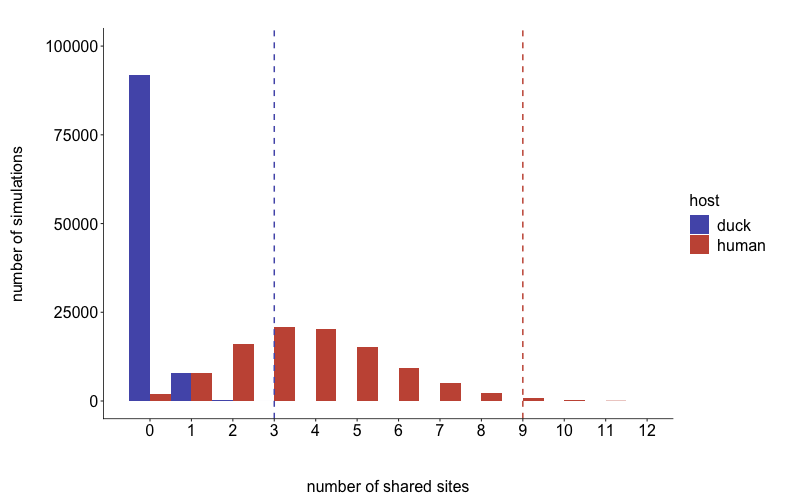

In [16]:
%%R -w 800 -h 500 -u px -i df,human_color,duck_color  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

p <- ggplot(data=df, aes(x=full_genome, stat="bin", binwidth=1, fill=host)) + 
    geom_histogram(position="dodge", binwidth=1)+
    geom_vline(xintercept=3, color=duck_color, linetype=2, size=0.7)+
    geom_vline(xintercept=9, color=human_color, linetype=2, size=0.7)+
    scale_x_continuous(breaks=c(0,1,2,3,4,5,6,7,8,9,10,11,12), limits=c(-0.5,12))+
    #scale_x_continuous(breaks=c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20), limits=c(-0.25,20))+
    scale_y_continuous(limits=c(0,100000))+
    labs(x="\nnumber of shared sites",y="number of simulations")+
    #ggtitle("shared sites in human random simulations (70% of genome tolerates mutation)") + 
    scale_fill_manual(values=c(duck_color,human_color))+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16))+
    theme(legend.text=element_text(size=16))+theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("Fig-3b-shared_sites_perm_test.pdf", p, width = 8, height = 5, path="figure-PDFs")
p

In [21]:
# ducks share 3 sites, humans share 9 sites
df_human = df[df['host'] == 'human']
pd.to_numeric(df_human['full_genome'])
df_human[df_human['full_genome'] >= 9.0].count()

index          1185
PB2            1185
PB1            1185
PA             1185
HA             1185
NP             1185
NA             1185
M1             1185
M2             1185
NS1            1185
NEP            1185
full_genome    1185
host           1185
dtype: int64

In [23]:
# ducks share 3 sites, humans share 9 sites
df_duck = df[df['host'] == 'duck']
pd.to_numeric(df_duck['full_genome'])
df_duck[df_duck['full_genome'] >= 3.0].count()

index          3
PB2            3
PB1            3
PA             3
HA             3
NP             3
NA             3
M1             3
M2             3
NS1            3
NEP            3
full_genome    3
host           3
dtype: int64

## Results

Because this is simulation based, the actual numbers change each time, but the results stay similar from instance to instance. 

Basically, this tells us that out of 100,000 simulations of random mutations, the vast majority of the time, there will be between 2 and 6 sites that are shared by chance alone in humans, and 0 to 1 sites shared in birds. Some simulations result in at least 9 shared sites in humans, and very few simulations resulted in >= 3 shared sites in ducks.

human p-value: 0.01185
duck p-value:  0.00003

Both humans and ducks share more variation than expected by chance alone. 

## Step 5: Different percentages of genome mutatable

Although this first pass seems like a reasonable way to assess how many shared sites we would expect to see by chance alone, I think it would also be useful to rerun the simulation with a smaller fraction of sites available to mutate. The idea I have here is that the vast majority of codon changes will be so deleterious that you would never expect to observe them in nature. What our results could be showing us is not necessarily that the shared sites we are seeing are mostly driven by adaptation, but rather they reflect random mutations in the small subset of mutations that are actually tolerated for these genes to still produce a functional protein, regardless of host species. So I would like to try out a few different values of limiting the number of possible amino acid site substitutions in line with estimates from the literature. 

This paper estimates a lethal fraction of about 30%: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5003363/

This review suggests that most viruses have lethal fractions ranging between 20-40%: https://royalsocietypublishing.org/doi/10.1098/rstb.2010.0063

In [37]:
# Assume that only some fraction of sites could actually have a mutation that you could observe 

fraction_of_gene_mutation_tolerated = 0.7

aa_coverages_human = {}
aa_coverages_duck = {}

for sample in coverage["human"]: 
    aa_coverages_human[sample] = {}
    for gene in coverage["human"][sample]: 
        
        nuc_sites = coverage["human"][sample][gene]
        aa_value = int(nuc_sites/(3 * (1/fraction_of_gene_mutation_tolerated)))
        aa_coverages_human[sample][gene] = aa_value

for sample in coverage["duck"]: 
    aa_coverages_duck[sample] = {}
    for gene in coverage["duck"][sample]: 
        
        nuc_sites = coverage["duck"][sample][gene]
        aa_value = int(nuc_sites/(3 * (1/fraction_of_gene_mutation_tolerated)))
        aa_coverages_duck[sample][gene] = aa_value

print(aa_coverages_human)

{'AJ4MBL723F512_A_CAMBODIA_V0401301_2011': {'PB2': 518, 'PB1': 513, 'PA': 494, 'HA': 224, 'NP': 329, 'NA': 301, 'M1': 166, 'M2': 60, 'NS1': 148, 'NEP': 72}, 'AJ4MBL718F513_A_CAMBODIA_V0417301_2011': {'PB2': 517, 'PB1': 523, 'PA': 496, 'HA': 333, 'NP': 339, 'NA': 301, 'M1': 165, 'M2': 60, 'NS1': 144, 'NEP': 71}, 'AJ4MBL720F513_A_Cambodia_W0112303_2012': {'PB2': 513, 'PB1': 521, 'PA': 498, 'HA': 338, 'NP': 337, 'NA': 300, 'M1': 167, 'M2': 61, 'NS1': 144, 'NEP': 71}, 'AJ4MBL720F514_A_Cambodia_X0125302_2013': {'PB2': 513, 'PB1': 518, 'PA': 497, 'HA': 155, 'NP': 338, 'NA': 303, 'M1': 166, 'M2': 62, 'NS1': 149, 'NEP': 75}, 'AA4KNL706F512_A_Cambodia_X0128304_2013': {'PB2': 518, 'PB1': 0, 'PA': 483, 'HA': 386, 'NP': 334, 'NA': 303, 'M1': 168, 'M2': 61, 'NS1': 151, 'NEP': 78}, 'AJ4MBL723F514_A_Cambodia_X0207301_2013': {'PB2': 516, 'PB1': 517, 'PA': 497, 'HA': 342, 'NP': 340, 'NA': 301, 'M1': 166, 'M2': 60, 'NS1': 142, 'NEP': 69}, 'AJ4MBL718F515_A_Cambodia_X0219301_2013': {'PB2': 518, 'PB1': 516

In [38]:
num_sims = 100000

data_human2 = simulate_shared_sites(SNPs_human2, aa_coverages_human, num_sims)
data_duck2 = simulate_shared_sites(SNPs_duck2, aa_coverages_duck, num_sims)

In [39]:
# convert to dataframe
df_human2 = pd.DataFrame(data_human2, columns=data_human2.keys())
df_human2 = df_human2.reset_index()
df_human2["full_genome"] = df_human2['PB2'] + df_human2['PB1'] + df_human2['PA'] + df_human2['HA'] + df_human2['NP'] + df_human2['NA'] + df_human2['M1'] + df_human2['M2'] + df_human2['NS1'] + df_human2['NEP']
df_human2["host"] = "human"

df_duck2 = pd.DataFrame(data_duck2, columns=data_duck2.keys())
df_duck2 = df_duck2.reset_index()
df_duck2["full_genome"] = df_duck2['PB2'] + df_duck2['PB1'] + df_duck2['PA'] + df_duck2['HA'] + df_duck2['NP'] + df_duck2['NA'] + df_duck2['M1'] + df_duck2['M2'] + df_duck2['NS1'] + df_duck2['NEP']
df_duck2["host"] = "duck"

df2 = pd.concat([df_human2, df_duck2])
df2.head()

,index,PB2,PB1,PA,HA,NP,NA,M1,M2,NS1,NEP,full_genome,host
0,0,1,1,1,0,0,2,0,0,0,0,5,human
1,1,0,0,1,3,0,0,1,1,0,0,6,human
2,2,1,0,1,3,0,0,1,0,1,0,7,human
3,3,0,3,3,1,1,0,0,0,0,0,8,human
4,4,0,0,1,0,2,0,0,0,0,0,3,human


In [40]:
%%R -w 800 -h 500 -u px -i df2,human_color,duck_color  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

p2 <- ggplot(data=df2, aes(x=full_genome, stat="bin", fill=host)) + 
    geom_histogram(position="dodge", binwidth=1)+
    geom_vline(xintercept=3, color=duck_color, linetype=2, size=0.7)+
    geom_vline(xintercept=9, color=human_color, linetype=2, size=0.7)+
    scale_x_continuous(limits=c(-0.5,20), breaks=c(0,2,4,6,8,10,12,14,16,18,20))+  
    scale_y_continuous(limits=c(0,100000))+
    labs(x="\nnumber of shared sites",y="number of simulations")+
    scale_fill_manual(values=c(duck_color,human_color))+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+theme(strip.text.x=element_text(size=11))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16))+
    theme(legend.text=element_text(size=16))+theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("Fig-5c-shared_sites_perm_test_70_percent.pdf", p2, width = 8, height = 5, path="figure-PDFs")
#ggsave("Fig-5d-shared_sites_perm_test_60_percent.pdf", p2, width = 8, height = 5, path="figure-PDFs")

In [41]:
df_human2 = df2[df2['host'] == 'human']
pd.to_numeric(df_human2['full_genome'])
df_human2[df_human2['full_genome'] >= 9.0].count()

index          8382
PB2            8382
PB1            8382
PA             8382
HA             8382
NP             8382
NA             8382
M1             8382
M2             8382
NS1            8382
NEP            8382
full_genome    8382
host           8382
dtype: int64

In [42]:
df_duck2 = df2[df2['host'] == 'duck']
pd.to_numeric(df_duck2['full_genome'])
df_duck2[df_duck2['full_genome'] >= 3.0].count()

index          17
PB2            17
PB1            17
PA             17
HA             17
NP             17
NA             17
M1             17
M2             17
NS1            17
NEP            17
full_genome    17
host           17
dtype: int64

## Results:
**70% of the genome can tolerate a mutation:**

8,382 out of 100,000 simulations had at least 9 sites shared in humans: p = 0.08382

17 simulations had at least 3 sites shared in ducks: p = 0.00017

**60% of the genome can tolerate a mutation:**

16,825 out of 100,000 simulations had at least 9 sites shared in humans: p = 0.168

21 simulations had at least 3 shared sites in ducks: p = 0.00021